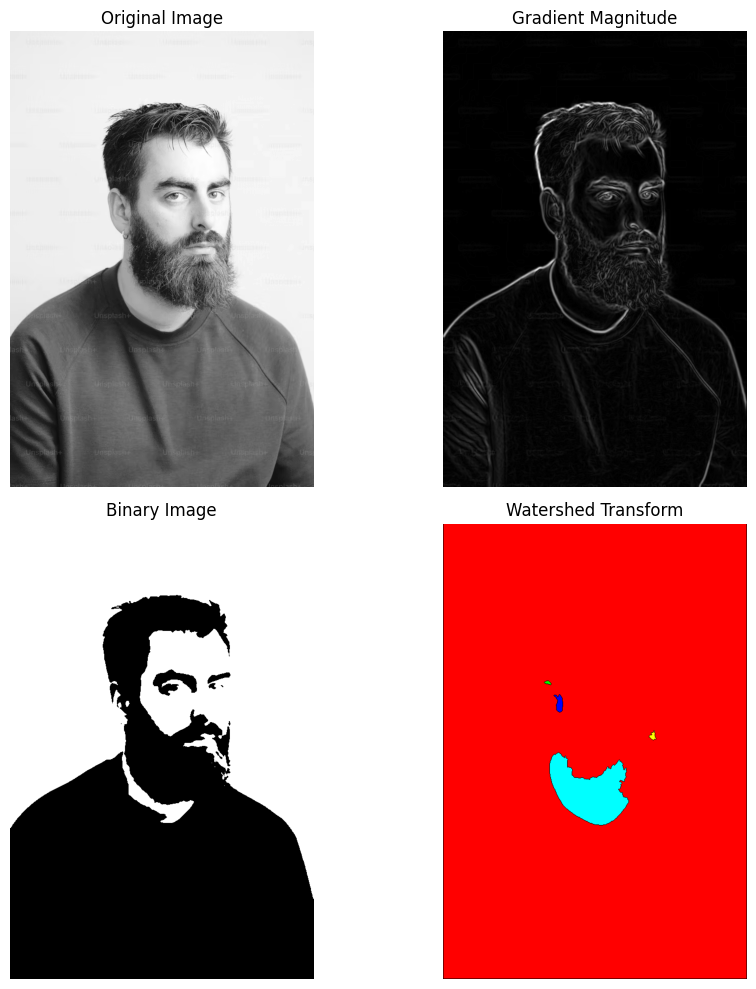

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

I = cv2.imread('/content/person.jpg')

# Check if the image is read correctly
if I is None:
    raise FileNotFoundError('Could not open or find the image.')

# Step 2: Convert to Grayscale (if necessary)
if len(I.shape) == 3:
    I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

# Step 3: Noise Reduction
I_filtered = cv2.GaussianBlur(I, (5, 5), 2)  # Apply Gaussian filter to reduce noise

# Step 4: Compute the Gradient Magnitude
sobelx = cv2.Sobel(I_filtered, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(I_filtered, cv2.CV_64F, 0, 1, ksize=3)
gradmag = np.sqrt(sobelx**2 + sobely**2)

# Step 5: Marker-Based Segmentation
_, binary_image = cv2.threshold(I_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
D = ndi.distance_transform_edt(binary_image)
local_max = cv2.dilate(cv2.erode(D, None), None)
markers, _ = ndi.label(local_max)
gradmag2 = cv2.watershed(cv2.cvtColor((gradmag * 255 / gradmag.max()).astype(np.uint8), cv2.COLOR_GRAY2BGR), markers)

# Step 6: Apply the Watershed Transform
labels = cv2.watershed(cv2.cvtColor(I_filtered, cv2.COLOR_GRAY2BGR), gradmag2)

# Step 7: Define 7 distinct colors for visualization
colors = [
    [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0],
    [0, 255, 255], [255, 0, 255], [192, 192, 192]
]

# Create an empty image for the result
Lrgb = np.zeros((*labels.shape, 3), dtype=np.uint8)

# Color the regions
for label in np.unique(labels):
    if label == -1:  # Ignore background
        continue
    mask = labels == label
    color_idx = (label - 1) % 7
    Lrgb[mask] = colors[color_idx]

# Step 8: Visualize the Results
plt.figure(figsize=(10, 10))

# Original Image
plt.subplot(2, 2, 1)
plt.imshow(I, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Gradient Magnitude
plt.subplot(2, 2, 2)
plt.imshow(gradmag, cmap='gray')
plt.title('Gradient Magnitude')
plt.axis('off')

# Binary Image
plt.subplot(2, 2, 3)
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image')
plt.axis('off')

# Watershed Transform
plt.subplot(2, 2, 4)
plt.imshow(Lrgb)
plt.title('Watershed Transform')
plt.axis('off')

plt.tight_layout()
plt.show()